In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import glob

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
#from tools.preprocess import preproc_maria,preproc_haiyan
sys.path.insert(1, '../')
import read_stuff as read
import ts_models
import properscoring as ps
from copy import deepcopy
#import benchmark
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
import random
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(8888)

In [3]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

16007

In [4]:
def prepare_tensors(filepath='./haiyan_store',splitnum=None,explag=23,notensor='No'):
    if './haiyan_store' in filepath:
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['test'][explag]
    elif filepath=='./maria_store':
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['test'][explag]
    
    X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
    X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
    X_totest, y_totest = read.delete_padding(Xtest,ytest)
    
    if notensor=='No':
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        #train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
        #val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
        #test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
        
        return {'train':[train_Xtensor,train_ytensor],'valid':[val_Xtensor,val_ytensor],'test':[test_Xtensor,test_ytensor]}
    elif notensor=='Yes':
        return {'train':[X_totrain, y_totrain],'valid':[X_tovalid, y_tovalid],'test':[X_totest, y_totest]}

storedata,store_notensor,store_low,store_axisym,store_upper,store_minus,store_addasym,store_minusasym,store_axisym_preserve = {},{},{},{},{},{},{},{},{}
for i in tqdm(range(0,40)):
    storedata[i] = prepare_tensors('./haiyan_store',i,23,'No')
    store_notensor[i] = prepare_tensors('./haiyan_store',i,23,'Yes')
    store_low[i] = prepare_tensors('./haiyan_store/sensitivity/lowlevel',i,23,'Yes')
    store_axisym[i] = prepare_tensors('./haiyan_store/sensitivity/axisym',i,23,'Yes')
    store_axisym_preserve[i] = prepare_tensors('./haiyan_store/sensitivity/axisym_preserve',i,23,'Yes')
    store_addasym[i] = prepare_tensors('./haiyan_store/sensitivity/asym',i,23,'Yes')
    store_minusasym[i] = prepare_tensors('./haiyan_store/sensitivity/minus_asym',i,23,'Yes')
    store_upper[i] = prepare_tensors('./haiyan_store/sensitivity/upperlevel',i,23,'Yes')
    store_minus[i] = prepare_tensors('./haiyan_store/sensitivity/minus_axisym',i,23,'Yes')

  0%|          | 0/40 [00:00<?, ?it/s]

In [5]:
import benchmark
import importlib
importlib.reload(benchmark)

<module 'benchmark' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/benchmark.py'>

# Performance Metrics

## VAE

In [6]:
losscoeffs = [0.45,0.55,0.65,0.75,0.85,0.95,1]#[0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
numsplit = 40
trailnums = 30
np.random.seed(8888)
seeds = np.random.randint(0, 500,size=20)

seeds_store = {}
for seed in seeds:
    crps_store_vae = {}
    for losscoeff in tqdm(losscoeffs):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='crps',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store[seed] = crps_store_vae
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
seeds_store_rmse = {}
for seed in seeds:
    crps_store_vae_rmse = {}
    for losscoeff in tqdm([0.75]):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae_rmse[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='rmse',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store_rmse[seed] = crps_store_vae_rmse

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
seeds_store_mae = {}
for seed in seeds:
    crps_store_vae_mae = {}
    for losscoeff in tqdm([0.75]):
        if (losscoeff==1):
            suffix=None
        else:
            suffix='_*best*'
        crps_store_vae_mae[losscoeff] = benchmark.get_performances_vae(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/vae/losscoeff_'+str(losscoeff)+'/',suffix=suffix,
                                                                   droprate=None,metric='mae',trailnums=trailnums,withspread=True,output_type='vae',seed=seed)
    seeds_store_mae[seed] = crps_store_vae_mae

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## MC Dropout

In [7]:
droprates = [0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
numsplit = 40
trailnums = 30

crps_store = {}
for nonln0 in tqdm([0,1,3]):#,1,3]):#,5,7,9,11]):
    crps_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/dropout_old/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='crps',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
rmse_store,mae_store = {},{}
for nonln0 in tqdm([0]):#,1,3]):#,5,7,9,11]):
    rmse_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/dropout_old/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='rmse',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}
for nonln0 in tqdm([0]):#,1,3]):#,5,7,9,11]):
    mae_store[nonln0] = {droprate: benchmark.get_performances_retrain(datasets=storedata,datasets_notensor=store_notensor,numsplits=numsplit,modelpath='./haiyan_store/dropout_old/nonln_'+str(nonln0)+'/',suffix='_*best*',
                                                               droprate=droprate,metric='mae',trailnums=trailnums,withspread=True,output_type='Drop1_2') for droprate in droprates}

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## CRPS

['#1b9e77', '#d95f02', '#7570b3', '#66a61e', '#e6ab02', '#a6761d', '#666666']


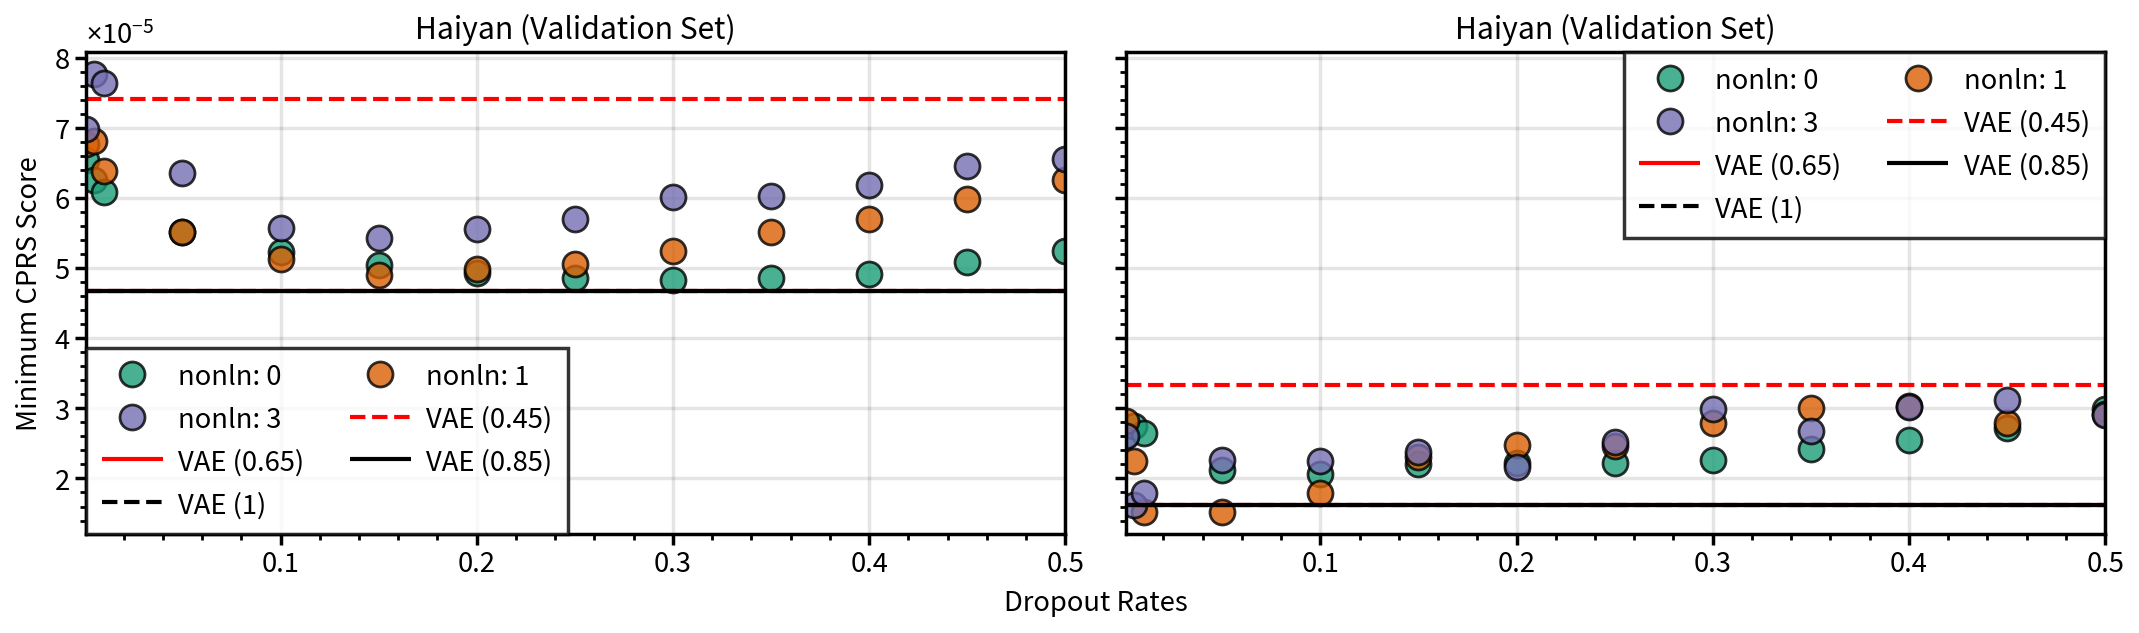

In [23]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'
from mycolorpy import colorlist as mcp
color1=mcp.gen_color(cmap="Dark2",n=7)
print(color1)

fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=2.031)
for ind,obj in enumerate([0,1,3]):#,5,7,9,11]):
    axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')

for ind,obj in enumerate([0,1,3]):#,1,3]):#,5,7,9,11]):
    axs[1].plot(droprates,[np.nanmin(read_and_proc.flatten([obj[i]['r2vals'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs.legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Minimum CPRS Score',title='Haiyan (Validation Set)',)#ylim=[0.5e-5,20.5e-5],xlim=[-0.01,0.525])
plt.savefig('./figures/SI_CRPS_haiyan_validate.png',dpi=600)
plt.show()

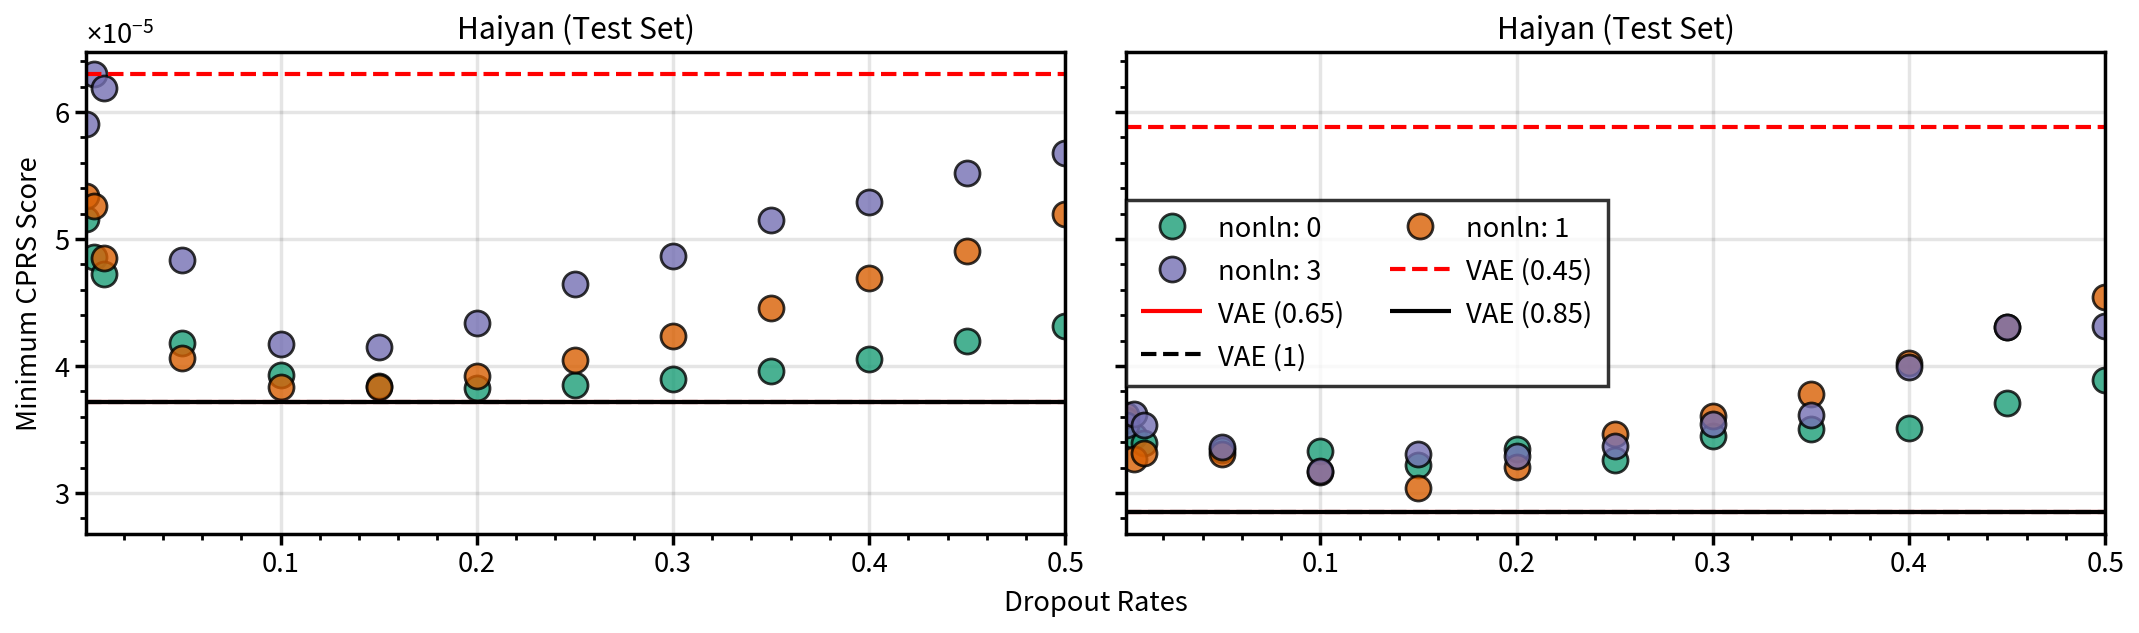

In [15]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=2.031)
for ind,obj in enumerate([0,1,3]):#,5,7,9,11]):
    axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')

for ind,obj in enumerate([0,1,3]):#,1,3]):#,5,7,9,11]):
    axs[1].plot(droprates,[np.nanmin(read_and_proc.flatten([obj[i]['r2tests'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs[1].legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Minimum CPRS Score',title='Haiyan (Test Set)',)#ylim=[0.5e-5,20.5e-5],xlim=[-0.01,0.525])
plt.savefig('./figures/SI_CRPS_haiyan_test.png',dpi=600)
plt.show()

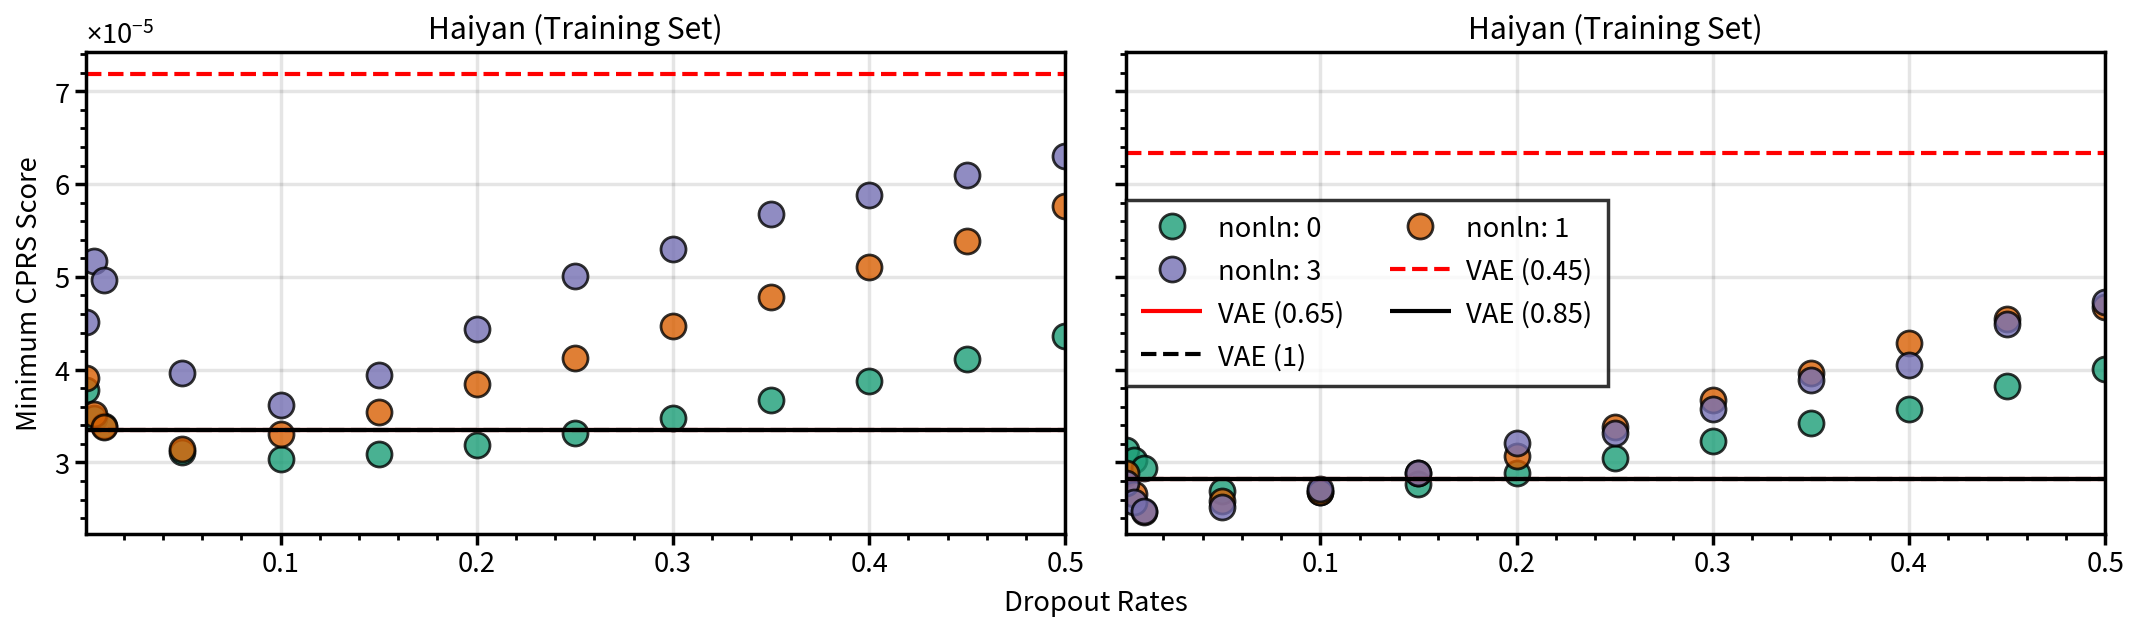

In [16]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=2.031)
for ind,obj in enumerate([0,1,3]):#,5,7,9,11]):
    axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2trains'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[0].axhline(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')

for ind,obj in enumerate([0,1,3]):#,1,3]):#,5,7,9,11]):
    axs[1].plot(droprates,[np.nanmin(read_and_proc.flatten([obj[i]['r2trains'] for i in range(40)])) for obj in list(crps_store[obj].values())],lw=0,label='nonln: '+str(obj),marker='o',mfc=color1[ind],
                mew=1,mec='k',markersize=9,alpha=0.8)

axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.45])])),color='r',ls='--',label='VAE (0.45)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.65])])),color='r',label='VAE (0.65)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.85])])),color='k',label='VAE (0.85)')
axs[1].axhline(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store_vae[0.95])])),color='k',ls='--',label='VAE (1)')
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2vals'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
#axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([obj[i]['r2tests'] for i in range(3)])) for obj in list(crps_performance.values())],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs[1].legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Minimum CPRS Score',title='Haiyan (Training Set)',)#ylim=[0.5e-5,20.5e-5],xlim=[-0.01,0.525])
plt.savefig('./figures/SI_CRPS_haiyan_train.png',dpi=600)
plt.show()

In [19]:
def report_vae_performance(storecc=None):
    train_median,train_min = [],[]
    valid_median,valid_min = [],[]
    test_median,test_min = [],[]

    for seed in seeds:
        train_median.append(np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (storecc[seed][0.75])])))
        valid_median.append(np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (storecc[seed][0.75])])))
        test_median.append(np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (storecc[seed][0.75])])))
        
        train_min.append(np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (storecc[seed][0.75])])))
        valid_min.append(np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (storecc[seed][0.75])])))
        test_min.append(np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (storecc[seed][0.75])])))
    return np.asarray(train_median),np.asarray(valid_median),np.asarray(test_median),np.asarray(train_min),np.asarray(valid_min),np.asarray(test_min)

In [20]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store)

In [21]:
train_median.mean(),valid_median.mean(),test_median.mean()

(3.3504970274788516e-05, 4.690849591656978e-05, 3.733862545719263e-05)

In [22]:
train_min.mean(),valid_min.mean(),test_min.mean()

(2.8263736342690845e-05, 1.6519522589099824e-05, 2.8578997131782945e-05)

In [12]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store[0][0.3])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store[0][0.3])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store[0][0.3])]))

(3.478664961668934e-05, 4.8292513184385684e-05, 3.898797188026595e-05)

In [13]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (crps_store[0][0.3])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (crps_store[0][0.3])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (crps_store[0][0.3])]))

(3.22842572037682e-05, 2.2567784708116644e-05, 3.449905987836264e-05)

## RMSE

In [27]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store_rmse)

In [28]:
train_median.mean(),valid_median.mean(),test_median.mean()

(5.3355263528981867e-05, 6.989561665280306e-05, 5.945804139872874e-05)

In [29]:
train_min.mean(),valid_min.mean(),test_min.mean()

(4.518538792164177e-05, 2.6103387553210194e-05, 4.829851650385248e-05)

In [25]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (rmse_store[0][0.3])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (rmse_store[0][0.3])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (rmse_store[0][0.3])]))

(5.676615536059214e-05, 7.167430226394917e-05, 6.0910405970896966e-05)

In [26]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (rmse_store[0][0.3])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (rmse_store[0][0.3])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (rmse_store[0][0.3])]))

(5.3526506726490557e-05, 3.666672664713574e-05, 5.54441865889903e-05)

## MAE

In [32]:
train_median,valid_median,test_median,train_min,valid_min,test_min = report_vae_performance(seeds_store_mae)

In [33]:
train_median.mean(),valid_median.mean(),test_median.mean()

(4.246988430965061e-05, 5.757403226314005e-05, 4.739167590317476e-05)

In [34]:
train_min.mean(),valid_min.mean(),test_min.mean()

(3.672508019269827e-05, 2.1536692244242626e-05, 3.745002397855683e-05)

In [30]:
np.nanmedian(read_and_proc.flatten([obj['r2trains'] for obj in (mae_store[0][0.3])])),np.nanmedian(read_and_proc.flatten([obj['r2vals'] for obj in (mae_store[0][0.3])])),\
np.nanmedian(read_and_proc.flatten([obj['r2tests'] for obj in (mae_store[0][0.3])]))

(4.5640000215244106e-05, 6.0040920230496765e-05, 4.9321450336837995e-05)

In [31]:
np.nanmin(read_and_proc.flatten([obj['r2trains'] for obj in (mae_store[0][0.3])])),np.nanmin(read_and_proc.flatten([obj['r2vals'] for obj in (mae_store[0][0.3])])),\
np.nanmin(read_and_proc.flatten([obj['r2tests'] for obj in (mae_store[0][0.3])]))

(4.276911161962762e-05, 2.961675802867072e-05, 4.308708338920413e-05)

## Spread-skill

In [8]:
import importlib,plotting
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
importlib.reload(plotting)

<module 'plotting' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/finalver/plotting.py'>

In [9]:
snum=2
coeff=0.75
splitno = 19
modelno = 0

def get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snum,coeff=coeff,splitno=splitno,modelno=modelno,category='valid',meancat='meanvals'):
    aaaaaa = [np.percentile(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category],i) for i in np.arange(0,95,5)]
    
    hihihi = []
    hihihib = []

    ssRel = 0
    nPts = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category]).size
    for i in range(len(aaaaaa)-1):
        ytruth = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['truth'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                         seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        nPtsbin = ytruth.size
        ypred = np.asarray(seeds_store[seeds[snum]][coeff][splitno][meancat][modelno])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                  seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))]
        spreadss = np.asarray(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category])[np.where(np.logical_and(seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]>aaaaaa[i],
                                                                                                                             seeds_store[seeds[snum]][coeff][splitno]['spreads'][modelno][category]<aaaaaa[i+1]))] 
        try:
            hihihi.append(np.sqrt(mean_squared_error(ytruth,ypred)))
            ssRel += (nPtsbin/nPts) * np.abs(np.sqrt(mean_squared_error(ytruth,ypred)) - np.mean(spreadss))
        except:
            hihihi.append(np.nan)
            ssRel += 0
    return {'spreadlim':aaaaaa,'error':hihihi,'ssRel':ssRel}

In [10]:
snum=2
coeff=0.75
splitno = 19
modelno = 0

allsave = []
for snumz in tqdm(np.linspace(0,19,20)):
    tmpsave_1 = {}
    for coeffz in losscoeffs:
        tmpsave_2 = []
        for splitnoz in range(39):
            snumz=int(snumz)
            tempsNUM = len(seeds_store[seeds[snumz]][coeffz][splitnoz]['truth'])
            tmpsave_3 = [get_spread_skill_score_model(seeds_store=seeds_store,seeds=seeds,snum=snumz,coeff=coeffz,splitno=splitnoz,modelno=i,category='valid',meancat='meanvals') for i in range(tempsNUM)]
            tmpsave_2.append(tmpsave_3)
        tmpsave_1[coeffz] = tmpsave_2
    allsave.append(tmpsave_1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
ssRels_array = np.zeros((39,9))
for i in (range(39)):
    for j in (range(9)):
        ssRels_array[i,j] = np.asarray([allsave[k][0.85][i][j]['ssRel'] for k in range(20)]).min()
        
#np.argwhere(ssRels_array == np.min(ssRels_array))
#np.dstack(np.unravel_index(np.argsort(ssRels_array.ravel()), ssRels_array.shape))

### Benchmark and Plotting

In [50]:
testst = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_allcriteria()
testst_flatten = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_criteria_flatten() #[70,74,78,82,86,90,94,98,100]
curves_models,ssrels = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_rmse_curve(testst_flatten)
ssrats = plotting.spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'train',crps_store[0],droprates).get_ssrat()

In [51]:
np.nanmedian(ssRels_array),np.nanmin(ssRels_array)

(2.6110772840283563e-05, 1.3050239813394564e-05)

In [52]:
np.nanmedian(np.asarray(ssrels[8])),np.nanmin(np.asarray(ssrels[8]))

(2.454822476740778e-05, 1.890482175250848e-05)

In [22]:
def get_vae_performance(storeresult=None):
    testst_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',storeresult,losscoeffs).get_allcriteria()
    testst_flatten_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',storeresult,losscoeffs).get_criteria_flatten()
    curves_models_vae,ssrels_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',storeresult,losscoeffs).get_rmse_curve(testst_flatten_vae)
    ssrats_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',storeresult,losscoeffs).get_ssrat()
    
    valsplit2_vaes = []
    modelnum2_vaes = []
    for ind,losscoefff in enumerate(losscoeffs):
        dropr_vae,valsplit2_vae,modelnum2_vae = ssrelminindex_vae,np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin(),\
        np.asarray(ssrels_vae[ssrelminindex_vae][np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin()]).argmin()
        valsplit2_vaes.append(valsplit2_vae)
        modelnum2_vaes.append(modelnum2_vae)
    return {'testst_flatten':testst_flatten_vae,'curve_models':curves_models_vae,'ssrels':ssrels_vae,'ssrats':ssrats_vae,'valsplit':valsplit2_vaes,'modelnum':modelnum2_vaes}

In [23]:
ssrelminindex_vae = 26
allvaes = {}
for seedvae in tqdm(seeds):
    allvaes[seedvae] = get_vae_performance(seeds_store[seedvae])

  0%|          | 0/20 [00:00<?, ?it/s]

KeyError: 26

In [ ]:
testst_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',seeds_store[seeds[0]],losscoeffs).get_allcriteria()
testst_flatten_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',seeds_store[seeds[0]],losscoeffs).get_criteria_flatten() #[70,74,78,82,86,90,94,98,100]
curves_models_vae,ssrels_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',seeds_store[seeds[0]],losscoeffs).get_rmse_curve(testst_flatten_vae)
#_,ssrels_orig_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',crps_store_vae,losscoeffs).get_rmse_curve(testst_flatten_vae)
ssrats_vae = plotting.spread_error_diagram([0,20,40,60,80,100],'valid',seeds_store[seeds[0]],losscoeffs).get_ssrat()

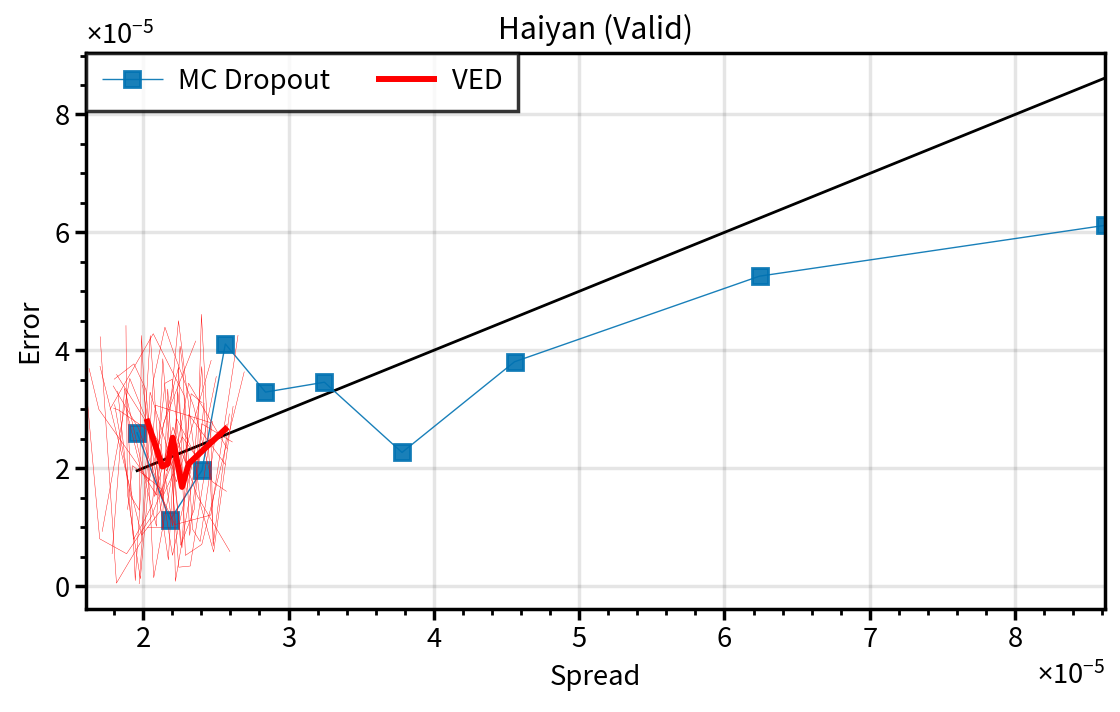

In [26]:
ssrelminindex,ssrelminindex_vae = 8,1
dropr,valsplit2,modelnum2 = ssrelminindex,np.asarray([np.asarray(obj).min() for obj in ssrels[ssrelminindex]]).argmin(),np.asarray(ssrels[ssrelminindex][np.asarray([np.asarray(obj).min() for obj in ssrels[ssrelminindex]]).argmin()]).argmin()
#dropr_vae,valsplit2_vae,modelnum2_vae = ssrelminindex_vae,np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin(),\
#np.asarray(ssrels_vae[ssrelminindex_vae][np.asarray([np.asarray(obj).min() for obj in ssrels_vae[ssrelminindex_vae]]).argmin()]).argmin()
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.095,refaspect=1.831,sharey=3)
axs[0].plot(testst_flatten[dropr][valsplit2][1:],testst_flatten[dropr][valsplit2][1:],color='k',lw=1)
curvefin = curves_models[dropr][valsplit2]
#plt.plot(testst_flatten[dropr][valsplit2][1:],curvefin[modelnum2],marker='s',lw=0.5,label=i,alpha=0.9)
axs[0].plot(testst_flatten[dropr][valsplit2][1:],curves_models[dropr][valsplit2][modelnum2],marker='s',lw=0.5,label='MC Dropout',alpha=0.9,)

hihihi = []
for snumz in np.linspace(0,19,20):
    newX = np.asarray(allsave[int(snumz)][0.65][26][8]['spreadlim'][1:])[~np.isnan(allsave[int(snumz)][0.65][26][8]['error'])]
    newY = np.asarray(allsave[int(snumz)][0.65][26][8]['error'])[~np.isnan(allsave[int(snumz)][0.65][26][8]['error'])]
    axs[0].plot(newX,newY,lw=0.15,color='r')
    hihihi.append(newY)
axs[0].plot(newX,np.mean(np.asarray(hihihi),axis=0),lw=2.15,color='r',label='VED')
#plt.plot(testst_flatten_vae[0][valsplit2_vae][1:],testst_flatten_vae[0][valsplit2_vae][1:],color='k',lw=1)
#axs[0].plot(testst_flatten_vae[dropr_vae][valsplit2_vae][1:],curves_models_vae[dropr_vae][valsplit2_vae][modelnum2_vae],marker='s',lw=0.5,label='VAE',alpha=0.9,)
axs[0].format(xlabel='Spread',ylabel='Error',title='Haiyan (Valid)')
plt.legend(loc=1)
plt.savefig('./figures/SI/SI_spreadskill_compare_haiyan_VED_MCDropout.png',dpi=600)
plt.show()

## Figure 2

In [12]:
import importlib
importlib.reload(benchmark)

bestmodel = seeds_store[seeds[0]][0.85][26]['models'][8]
ALW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[26]['train'][0],bestmodel,'LW',[-40,-20])
ASW = benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[26]['train'][0],bestmodel,'SW',[-40,-20])
B = benchmark.analysis_patterns(None,None).new_b_vae(store_notensor[26]['train'][0],bestmodel,[-40,-20])#+5.4267e-05*np.exp(0.5)+2.6588e-05*np.exp(0.5)
#5.4267e-05*(0.5*benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[26]['train'][0],bestmodel,'LW_logvar',[-40,-20])*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl))+\
#           2.6588e-05*(0.5*benchmark.analysis_patterns(None,None).new_coeff_vae(store_notensor[26]['train'][0],bestmodel,'SW_logvar',[-40,-20])*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],fl))

pcalw,pcasw = read_and_proc.depickle('./haiyan_store/pca/lw/'+str(26)+'/PCA3D.pkg'),read_and_proc.depickle('./haiyan_store/pca/sw/'+str(26)+'/PCA3D.pkg')
fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[26]['train'][0],bestmodel,'LW')
fl_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[26]['train'][0],bestmodel,'LW_logvar')
flsw_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[26]['train'][0],bestmodel,'SW_logvar')
flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[26]['train'][0],bestmodel,'SW')
flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
flas_logvar = np.squeeze(np.dot(fl_logvar,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
flsws_logvar = np.squeeze(np.dot(flsw_logvar,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
#flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)

In [13]:
valsplit_vae=26
LW = (np.asarray(store_notensor[26]['train'][0])[:,-40:-20])
SW = (np.asarray(store_notensor[26]['train'][0])[:,-20:])
sssss = np.sum((benchmark.model_outweights_all(bestmodel)[0][2][0].detach().numpy()/np.std(LW,axis=0)*np.mean(LW,axis=0)))
sssss_sw = np.sum((benchmark.model_outweights_all(bestmodel)[0][6][0].detach().numpy()/np.std(SW,axis=0)*np.mean(SW,axis=0)))
NINN = np.random.randn(1)*5.4267e-05*(np.exp(0.5*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl_logvar))*np.exp(-1.6324/2)/np.exp(0.5*sssss))+\
            np.random.randn(1)*(2.6588e-05*(np.exp(0.5*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],flsw_logvar))*np.exp(-1.3649/2)/np.exp(0.5*sssss_sw)))
AAAAAAA = ALW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl)+ASW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],flsw)+B+NINN

### Plotting Fig 2

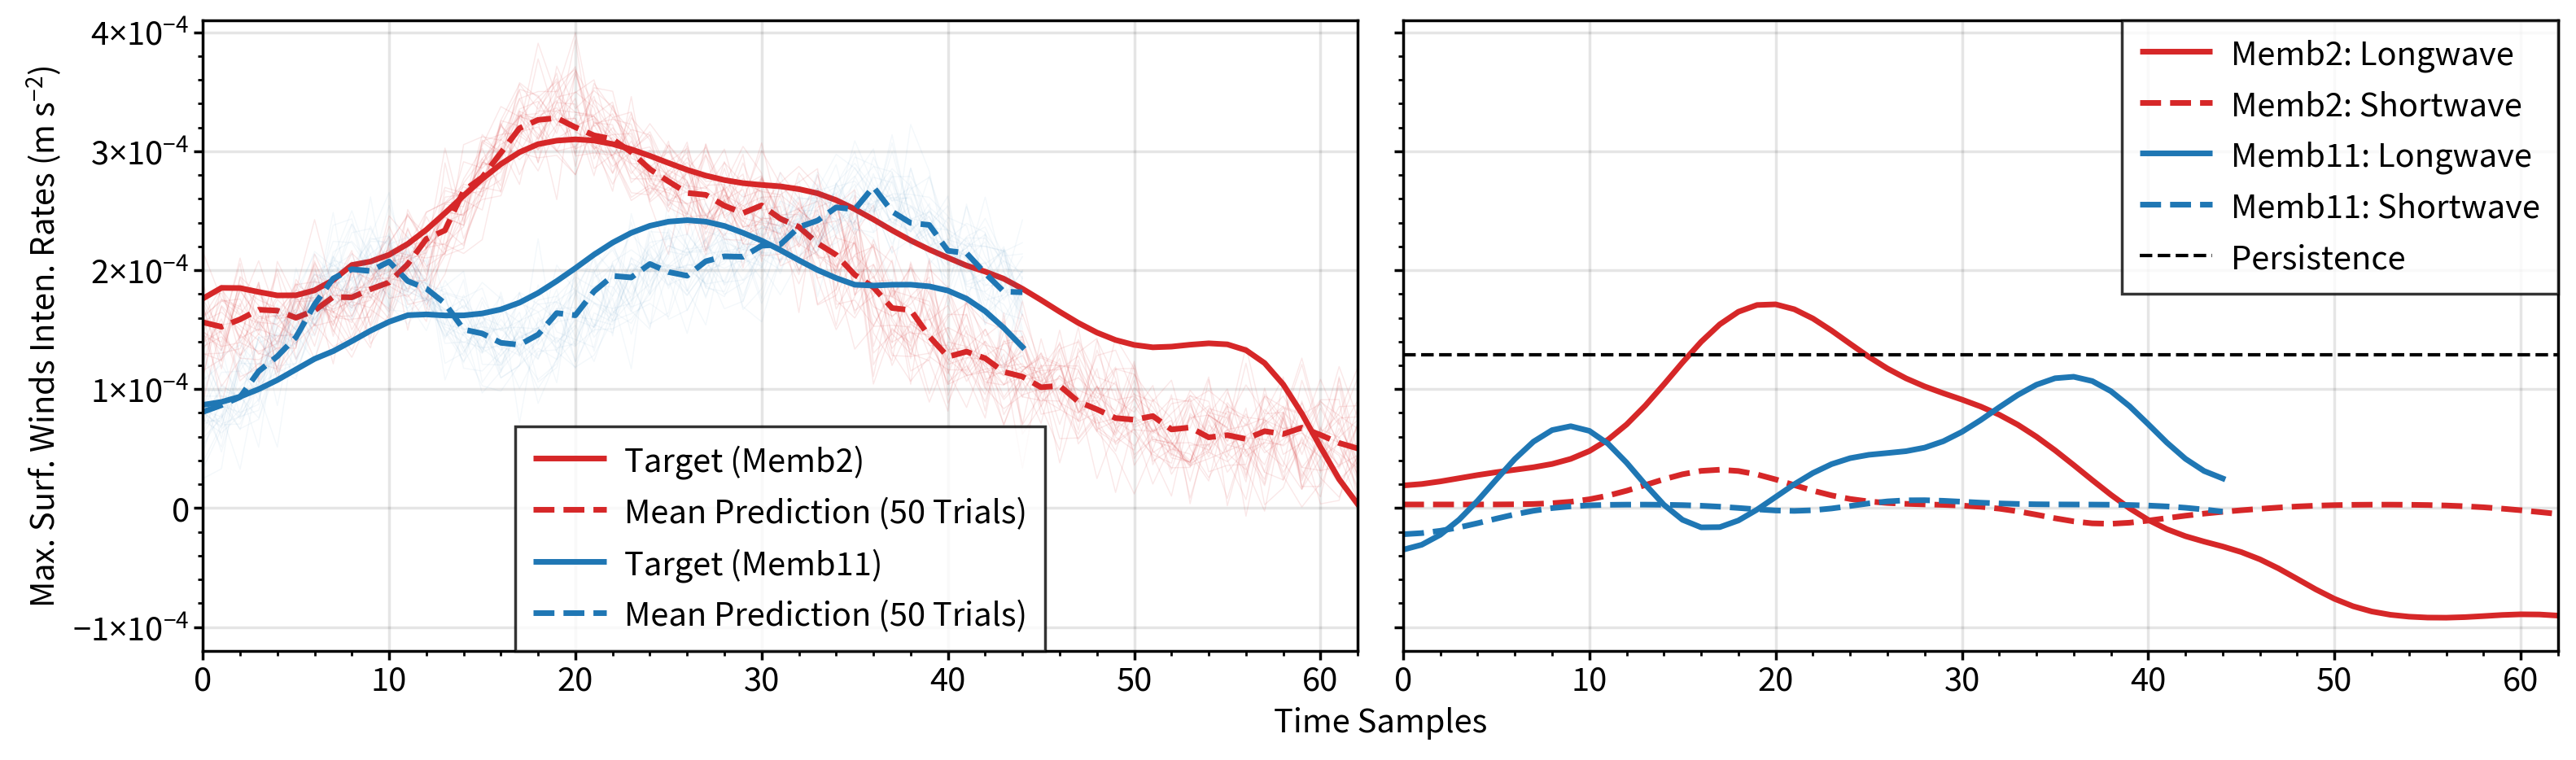

In [17]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.85
valsplit_vae=26
modelnum=8

fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=7.095,refaspect=1.831,sharey=3)
axs[0].plot(store_notensor[valsplit_vae]['train'][1][132:195],label=f'Target (Memb2)',c='tab:red',lw=2.5)#79:132])
axs[0].plot(seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['meantrains'][int(modelnum)][132:195],label='Mean Prediction (50 Trials)',c='tab:red',lw=2.5,ls='--')#79:132])
allpreds = seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(pred[132:195],c='tab:red',lw=0.5,alpha=0.105)
    
axs[0].plot(store_notensor[valsplit_vae]['train'][1][610:655],label=f'Target (Memb11)',c='tab:blue',lw=2.5)#79:132])
axs[0].plot(seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['meantrains'][int(modelnum)][610:655],label='Mean Prediction (50 Trials)',c='tab:blue',lw=2.5,ls='--')#79:132])
allpreds = seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['alltrains'][int(modelnum)]
for pred in allpreds:
    axs[0].plot(pred[610:655],c='tab:blue',lw=0.5,alpha=0.05)
    
axs[0].legend(loc=1,ncols=1)
#r2_scoress = r2_score(store_notensor[valsplit_vae]['train'][1],r2_performance[accesscode][int(valsplit_vae)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates (m s$^{-2}$)')#,ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(ALW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl)[132:195],label='Memb2: Longwave',c='tab:red',lw=2.5)#79:132])
axs[1].plot(ASW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],flsw)[132:195],label='Memb2: Shortwave',c='tab:red',lw=2.5,ls='--')
#axs[1].plot(ALW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl)[558:606],label='Memb11: Longwave',c='tab:blue',lw=2.5)#79:132])
#axs[1].plot(ASW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],flsw)[558:606],label='Memb11: Shortwave',c='tab:blue',lw=2.5,ls='--')
axs[1].plot(ALW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl)[610:655],label='Memb11: Longwave',c='tab:blue',lw=2.5)#79:132])
axs[1].plot(ASW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-20:],flsw)[610:655],label='Memb11: Shortwave',c='tab:blue',lw=2.5,ls='--')
#axs[1].plot((seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['meantrains'][int(modelnum)]-AAAAAAA-NINN)[132:195])
axs[1].axhline(y=B,label='Persistence',c='k',lw=1.5,ls='--')
axs[1].legend(loc=1,ncols=1)
axs[1].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-2}$)',ylim=[-0.00012,0.00041])#,xlim=[10,118-15])
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
plt.savefig('./figures/paper_fig2_haiyan_revised.png',dpi=600)
plt.show()

In [36]:
seeds_store[seeds[0]][accesscode][int(valsplit_vae)]['meantrains'][int(modelnum)][610:655][16]

0.00013893445

In [13]:
(hihihi_am)[132:195][38],(heyhey_a)[132:195][38]

(1.5616172442767176e-05, -4.281665108440076e-07)

### Sensitivity Experiment

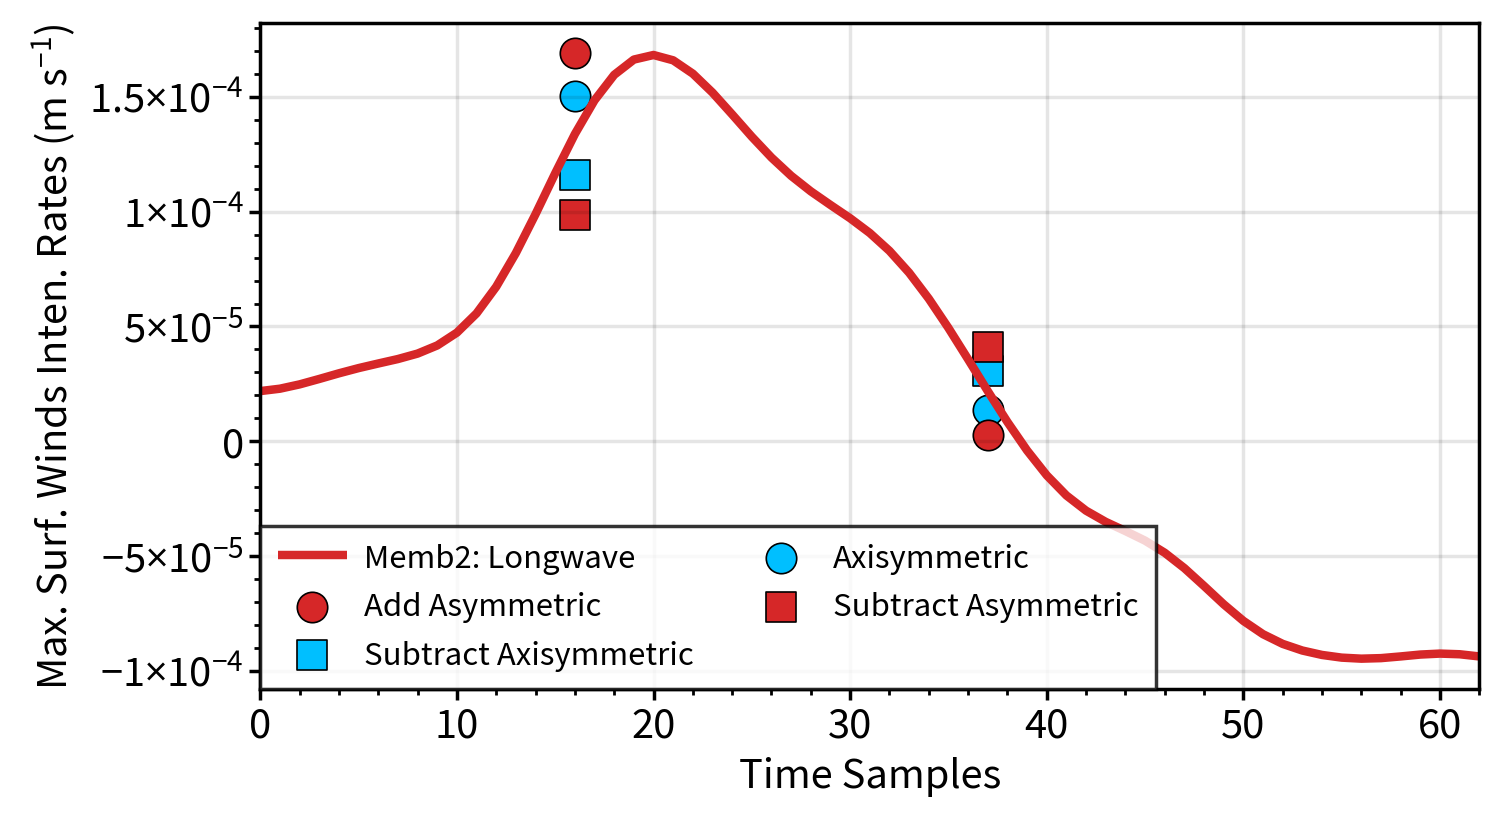

In [34]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=6.095,refaspect=1.831,sharey=3)
hihihi_a = ALW*np.dot(np.asarray(store_axisym_preserve[26]['train'][0])[:,-40:-20],fl)
hihihi_am = ALW*np.dot(np.asarray(store_minus[26]['train'][0])[:,-40:-20],fl)
heyhey_a = ALW*np.dot(np.asarray(store_addasym[26]['train'][0])[:,-40:-20],fl)
heyhey_am = ALW*np.dot(np.asarray(store_minusasym[26]['train'][0])[:,-40:-20],fl)
axs[0].scatter(16,(hihihi_a)[132:195][16],label='Axisymmetric',s=120,edgecolors='k',c='deepskyblue')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[0].scatter(16,(heyhey_a)[132:195][16],label='Add Asymmetric',s=120,edgecolors='k',c='tab:red')
axs[0].scatter(16,(heyhey_am)[132:195][16],label='Subtract Asymmetric',s=120,edgecolors='k',c='tab:red',marker='s')
axs[0].scatter(16,(hihihi_am)[132:195][16],label='Subtract Axisymmetric',s=120,edgecolors='k',c='deepskyblue',marker='s')#-np.mean(hihihi_a))/np.std(hihihi_a))
#axs[0].scatter(38,(hihihi_a)[132:195][38],s=120,edgecolors='r',c='w')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[0].scatter(37,(hihihi_am)[132:195][37],s=120,edgecolors='k',c='deepskyblue',marker='s')
axs[0].scatter(37,(hihihi_a)[132:195][37],s=120,edgecolors='k',c='deepskyblue')
axs[0].scatter(37,(heyhey_a)[132:195][37],s=120,edgecolors='k',c='tab:red')
axs[0].scatter(37,(heyhey_am)[132:195][37],s=120,edgecolors='k',c='tab:red',marker='s')
#-np.mean(hihihi_a))/np.std(hihihi_a))
#axs[0].scatter(38,(hihihi_am)[132:195][38],s=120,edgecolors='r',c='w',marker='s')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[0].plot(ALW*np.dot(np.asarray(store_notensor[valsplit_vae]['train'][0])[:,-40:-20],fl)[132:195],label='Memb2: Longwave',c='tab:red',lw=3.05)
#hihihi_a = ALW*np.dot(np.asarray(store_low[26]['train'][0])[:,-40:-20],fl)
#plt.plot((hihihi_a-np.mean(hihihi_a))/np.std(hihihi_a))
axs[0].format(xlabel='Time Samples',ylabel=r'Max. Surf. Winds Inten. Rates (m s$^{-1}$)')#,xlim=[10,118-15])
axs[0].yaxis.set_major_formatter(plot.Formatter(('sci')))
plt.legend(loc=1,ncols=2,prop={'size':12.5})
plt.savefig('./figures/SI/paper_fig4_haiyan_perturbinput.png',dpi=600)
plt.show()

### SI

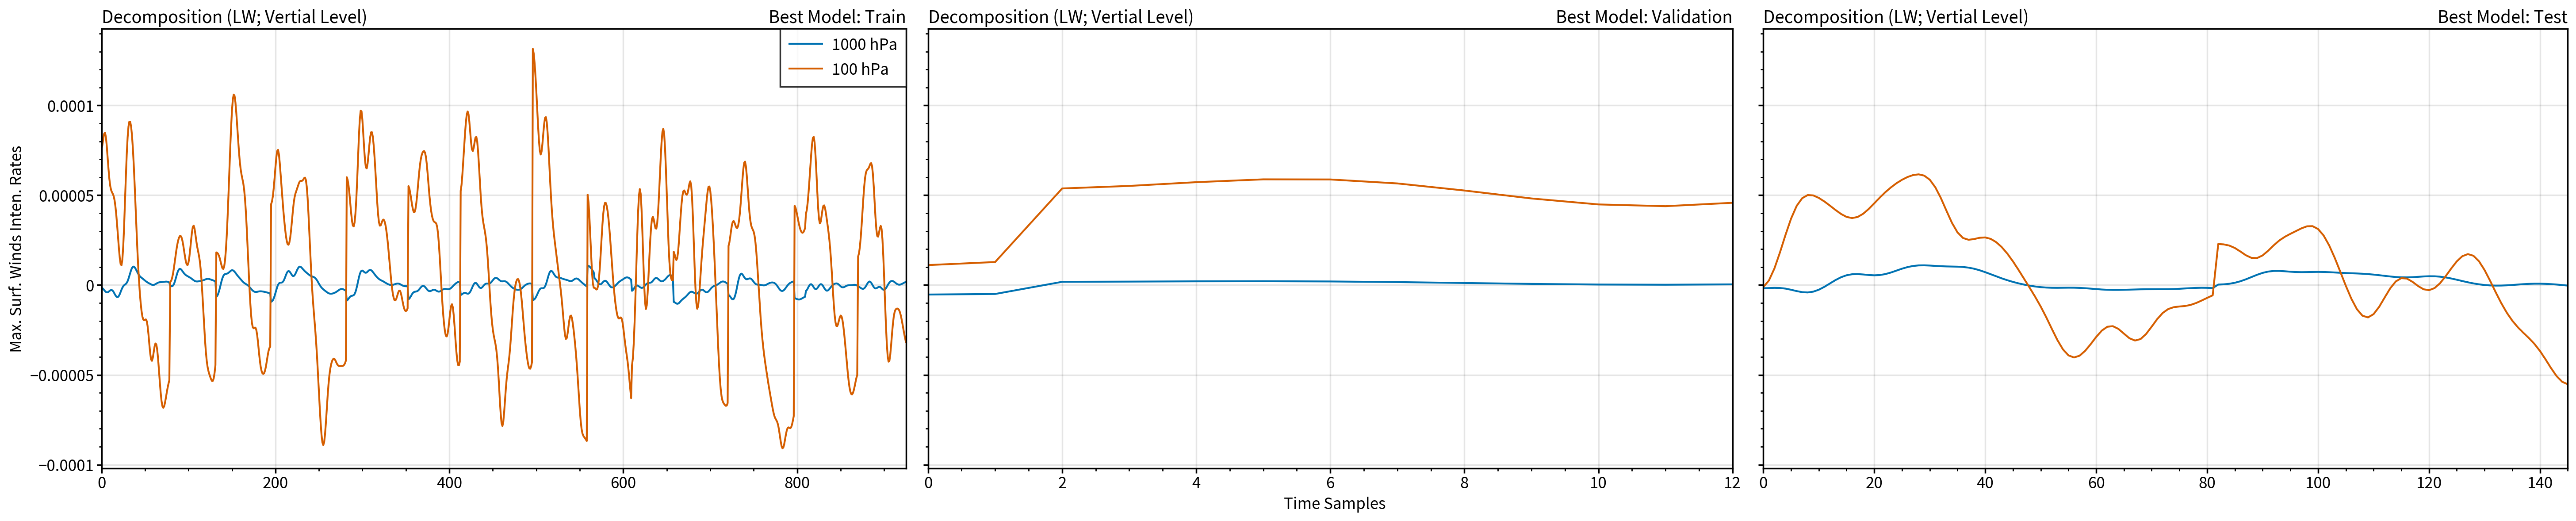

In [51]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=9.095,refaspect=1.831,sharey=3)
hihihi_a = ALW*np.dot(np.asarray(store_low[26]['train'][0])[:,-40:-20],fl)
axs[0].plot((hihihi_a),label='1000 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
hihihi_a = ALW*np.dot(np.asarray(store_upper[26]['train'][0])[:,-40:-20],fl)
axs[0].plot((hihihi_a),label='100 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Decomposition (LW; Vertial Level)',rtitle=f'Best Model: Train')
axs[0].legend(loc=1,ncols=1)

hihihi_a = ALW*np.dot(np.asarray(store_low[26]['valid'][0])[:,-40:-20],fl)
axs[1].plot((hihihi_a),label='1000 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
hihihi_a = ALW*np.dot(np.asarray(store_upper[26]['valid'][0])[:,-40:-20],fl)
axs[1].plot((hihihi_a),label='100 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Decomposition (LW; Vertial Level)',rtitle=f'Best Model: Validation')

hihihi_a = ALW*np.dot(np.asarray(store_low[26]['test'][0])[:,-40:-20],fl)
axs[2].plot((hihihi_a),label='1000 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
hihihi_a = ALW*np.dot(np.asarray(store_upper[26]['test'][0])[:,-40:-20],fl)
axs[2].plot((hihihi_a),label='100 hPa')#-np.mean(hihihi_a))/np.std(hihihi_a))
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Decomposition (LW; Vertial Level)',rtitle=f'Best Model: Test')
plt.savefig('./figures/SI/LW_decompose_vertlv.png',dpi=600)
plt.show()

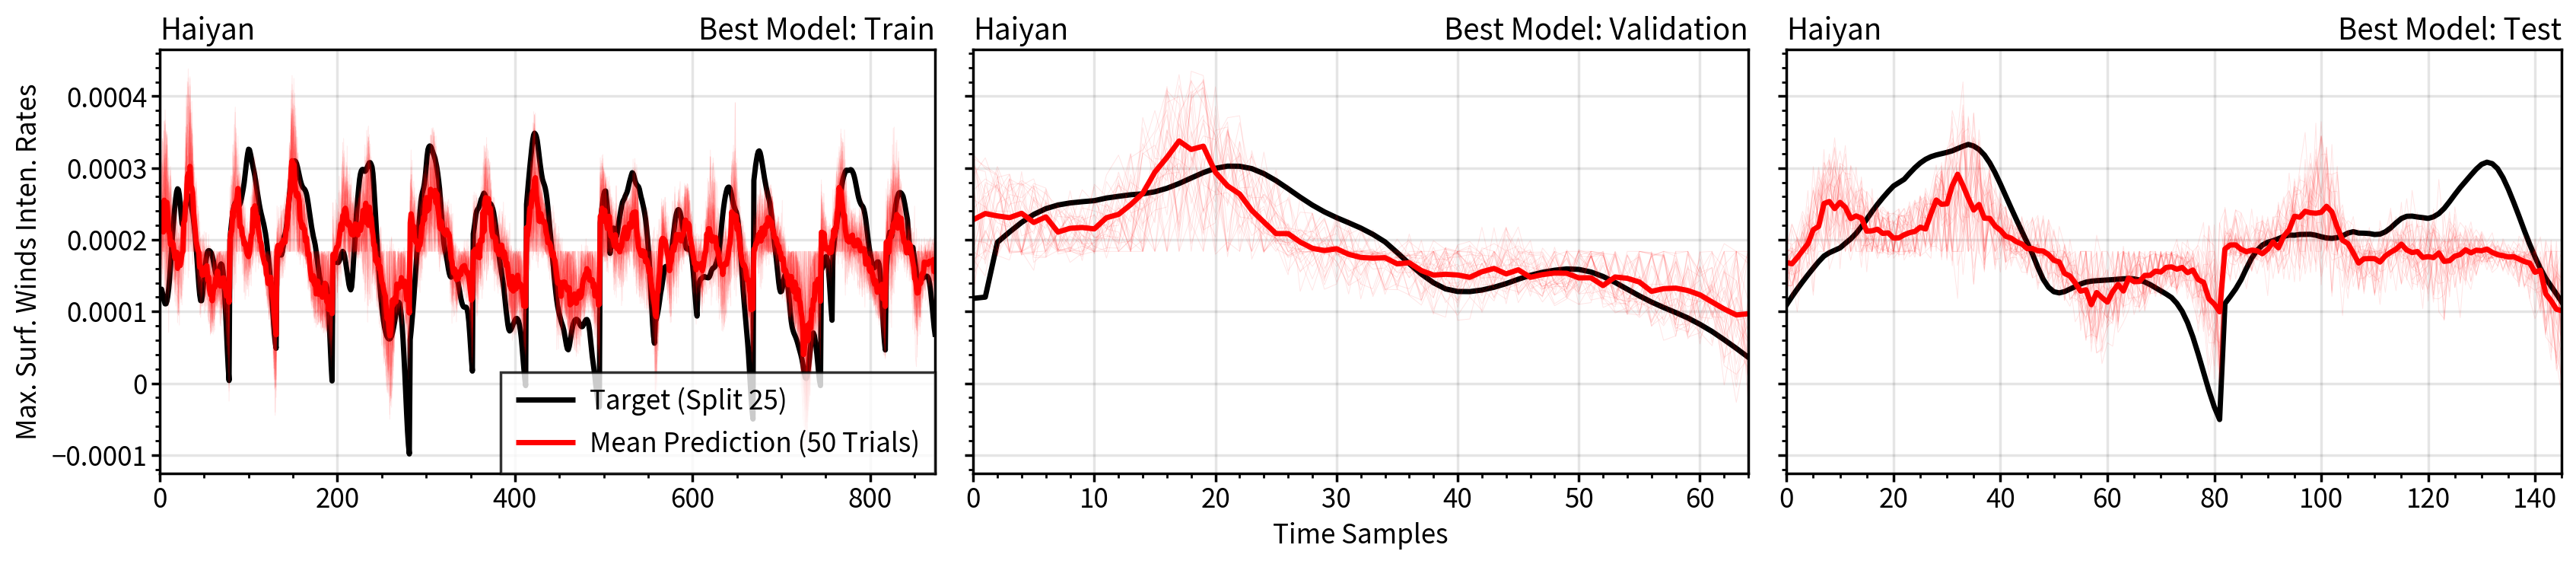

In [33]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.3
r2_performance = crps_store[0]
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831,sharey=3)
axs[0].plot(store_notensor[valsplit2]['train'][1],label=f'Target (Split {valsplit2})',c='k',lw=2.5)#79:132])
axs[0].plot(crps_store[0][accesscode][int(valsplit2)]['meantrains'][int(modelnum2)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store[0][accesscode][int(valsplit2)]['alltrains'][int(modelnum2)]
for pred in allpreds:
    axs[0].plot(pred,c='r',lw=0.35,alpha=0.085)
axs[0].legend(loc=4,ncols=1)
#r2_scoress = crps_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(store_notensor[valsplit2]['valid'][1],label=f'Target (Split {valsplit2})',c='k',lw=2.5)#79:132])
axs[1].plot(crps_store[0][accesscode][int(valsplit2)]['meanvals'][int(modelnum2)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store[0][accesscode][int(valsplit2)]['allvals'][int(modelnum2)]
for pred in allpreds:
    axs[1].plot(pred,c='r',lw=0.35,alpha=0.105)
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(store_notensor[valsplit2]['test'][1],label=f'Target (Split {valsplit2})',c='k',lw=2.5)#79:132])
axs[2].plot(crps_store[0][accesscode][int(valsplit2)]['meantests'][int(modelnum2)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store[0][accesscode][int(valsplit2)]['alltests'][int(modelnum2)]
for pred in allpreds:
    axs[2].plot(pred,c='r',lw=0.35,alpha=0.105)
#r2_scoress = r2_score(y_totest,r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)])
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')

plt.savefig('./figures/SI/paper_si_haiyan_revised_bestlinear.png',dpi=600)
plt.show()

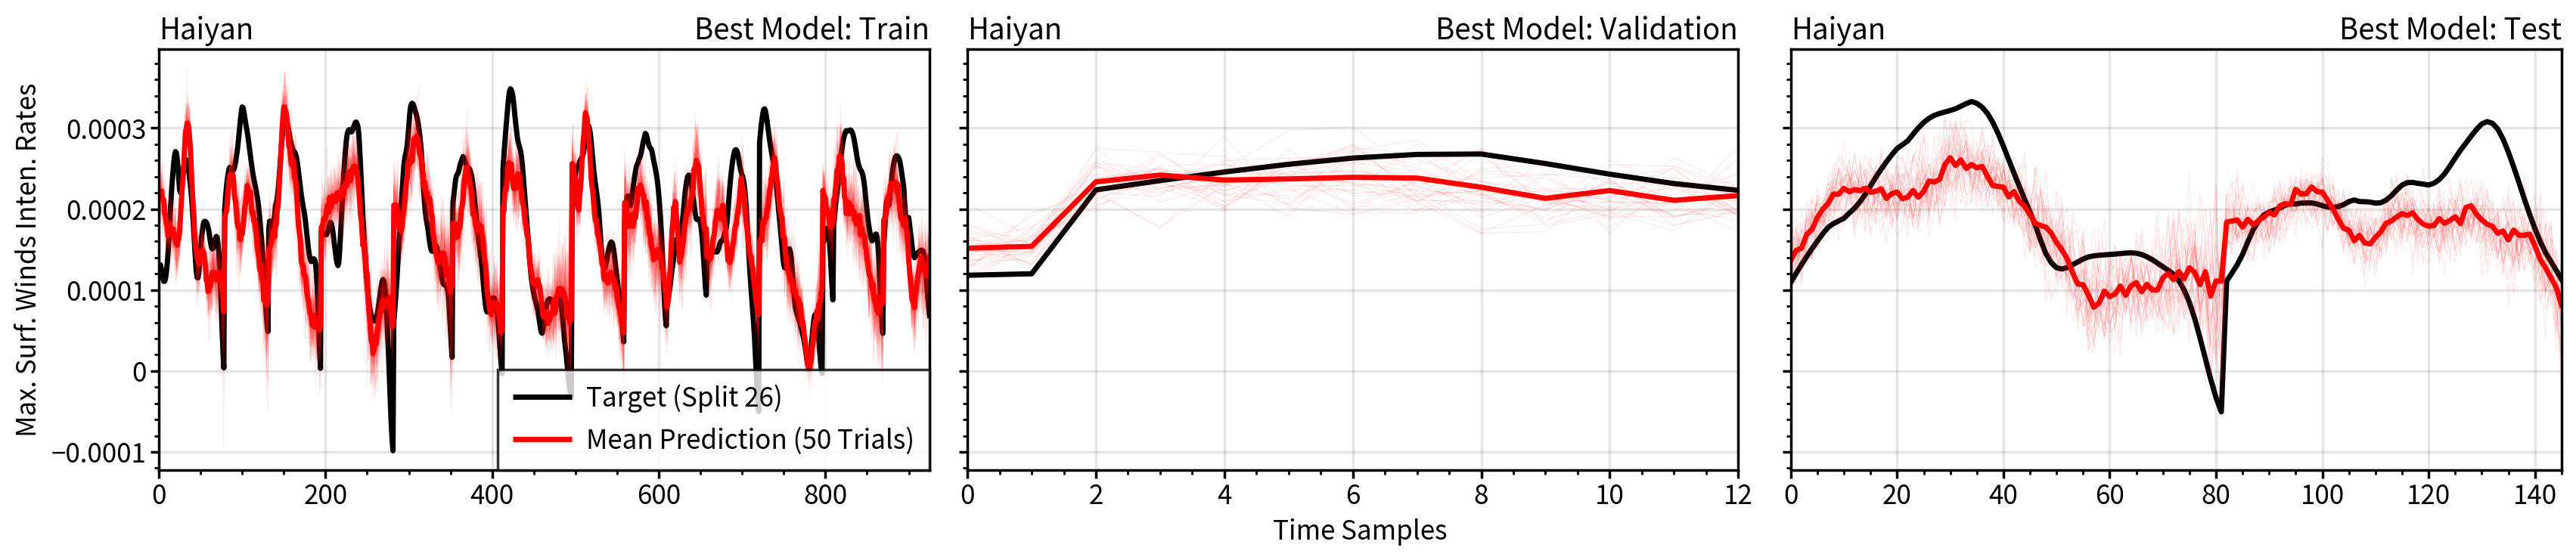

In [34]:
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

accesscode = 0.75
valsplit2_vae=26
modelnum2_vae=8
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831,sharey=3)
axs[0].plot(store_notensor[valsplit2_vae]['train'][1],label=f'Target (Split {valsplit2_vae})',c='k',lw=2.5)#79:132])
axs[0].plot(crps_store_vae[accesscode][int(valsplit2_vae)]['meantrains'][int(modelnum2_vae)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store_vae[accesscode][int(valsplit2_vae)]['alltrains'][int(modelnum2_vae)]
for pred in allpreds:
    axs[0].plot(pred,c='r',lw=0.35,alpha=0.085)
axs[0].legend(loc=4,ncols=1)
#r2_scoress = crps_score(store_notensor[valsplit]['train'][1],r2_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Train')

axs[1].plot(store_notensor[valsplit2_vae]['valid'][1],label=f'Target (Split {valsplit2_vae})',c='k',lw=2.5)#79:132])
axs[1].plot(crps_store_vae[accesscode][int(valsplit2_vae)]['meanvals'][int(modelnum2_vae)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store_vae[accesscode][int(valsplit2_vae)]['allvals'][int(modelnum2_vae)]
for pred in allpreds:
    axs[1].plot(pred,c='r',lw=0.35,alpha=0.105)
#r2_scoress = r2_score(y_toval,r2_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(store_notensor[valsplit2_vae]['test'][1],label=f'Target (Split {valsplit2_vae})',c='k',lw=2.5)#79:132])
axs[2].plot(crps_store_vae[accesscode][int(valsplit2_vae)]['meantests'][int(modelnum2_vae)],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store_vae[accesscode][int(valsplit2_vae)]['alltests'][int(modelnum2_vae)]
for pred in allpreds:
    axs[2].plot(pred,c='r',lw=0.35,alpha=0.105)
#r2_scoress = r2_score(y_totest,r2_performance[accesscode][int(valsplit)]['meantests'][int(modelnum)])
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')

plt.savefig('./figures/SI/paper_si_haiyan_revised_bestvae.png',dpi=600)
plt.show()

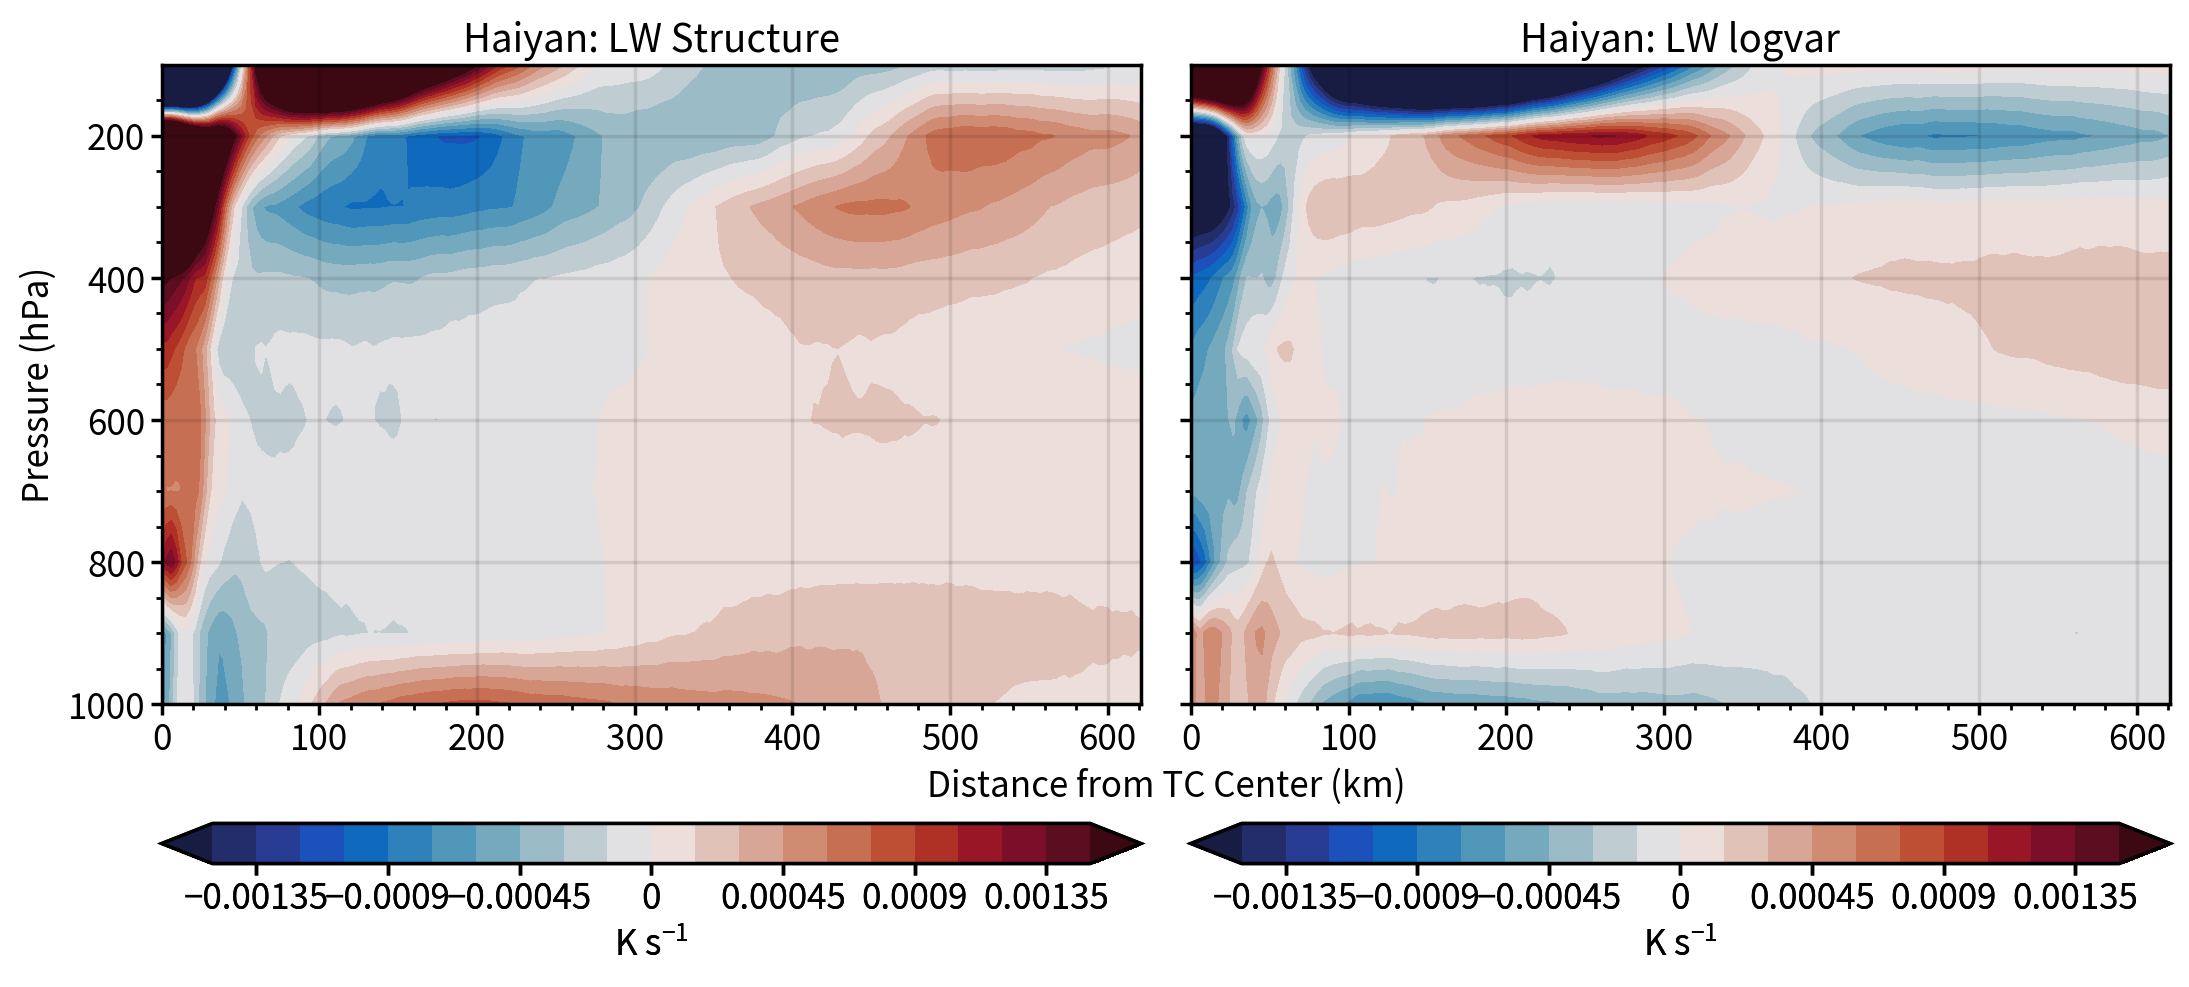

In [53]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.895,refaspect=1.531)
img = axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(flas,axis=1),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')#vmin=-0.5e-5,vmax=0.5e-5)
axs[0].colorbar(img,loc='b',label='K s$^{-1}$')
axs[0].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Haiyan: LW Structure')
img2 = axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),(np.mean(flas_logvar,axis=1)),cmap='balance',levels=np.linspace(-1.5e-3,1.5e-3,21),extend='both')
axs[1].colorbar(img2,loc='b',label='K s$^{-1}$')
axs[1].format(xlabel='Distance from TC Center (km)',ylabel='Pressure (hPa)',title='Haiyan: LW logvar')
#plt.savefig('./figures/optimstructures2D_revised_haiyan.png',dpi=600)
plt.show()

# Figure 4

In [18]:
splitnum=[26,26,26,26,30,19,26,26,29,26]
mdlnum = [8,4,2,0,0,5,3,5,5,7]

storeLW,storeSW,storeLW_logvar = [],[],[]
storeTS = []
for splitz,mdlnum in zip(splitnum,mdlnum):
    sdnum = np.asarray([allsave[k][0.85][splitz][mdlnum]['ssRel'] for k in range(20)]).argmin()
    bestmodel = seeds_store[seeds[sdnum]][0.85][splitz]['models'][mdlnum]
    pcalw,pcasw = read_and_proc.depickle('./haiyan_store/pca/lw/'+str(splitz)+'/PCA3D.pkg'),read_and_proc.depickle('./haiyan_store/pca/sw/'+str(splitz)+'/PCA3D.pkg')
    fl = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW')
    flsw = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW')
    fl_logvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'LW_logvar')
    fl_swlogvar = benchmark.analysis_patterns(None,None).new_structure_vae(store_notensor[splitz]['train'][0],bestmodel,'SW_logvar')
    flas = np.squeeze(np.dot(fl,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_sw = np.squeeze(np.dot(flsw,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    flas_lwlogvar = np.squeeze(np.dot(fl_logvar,pcalw['lw'].components_[:20,:])).reshape(10,360,208)
    flas_swlogvar = np.squeeze(np.dot(fl_swlogvar,pcasw['sw'].components_[:20,:])).reshape(10,360,208)
    TS_lw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl)
    TS_lwlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-40:-20],fl_logvar)
    TS_sw = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],flsw)
    TS_swlogvar = np.dot(np.asarray(store_notensor[splitz]['train'][0])[:,-20:],fl_swlogvar)
    storeLW.append(flas)
    storeSW.append(flas_sw)
    storeLW_logvar.append(flas_lwlogvar)
    storeTS.append({'lw':TS_lw,'sw':TS_sw,'lw_logvar':TS_lwlogvar,'sw_logvar':TS_swlogvar})

In [19]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
suffixRAD = '_smooth_preproc_dict1b_g_radcomp'
#haiyan_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['LW'] for lime in tqdm(range(1,21))]
#haiyan_sw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['SW'] for lime in tqdm(range(1,21))]
haiyan_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))]
haiyan_v = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))]
#haiyan_hdia = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))]

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
so = []
for index in range(40):
    so.append(read._get_exp_name(folderpath2,index,'rhorig','fixTEST')[1])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

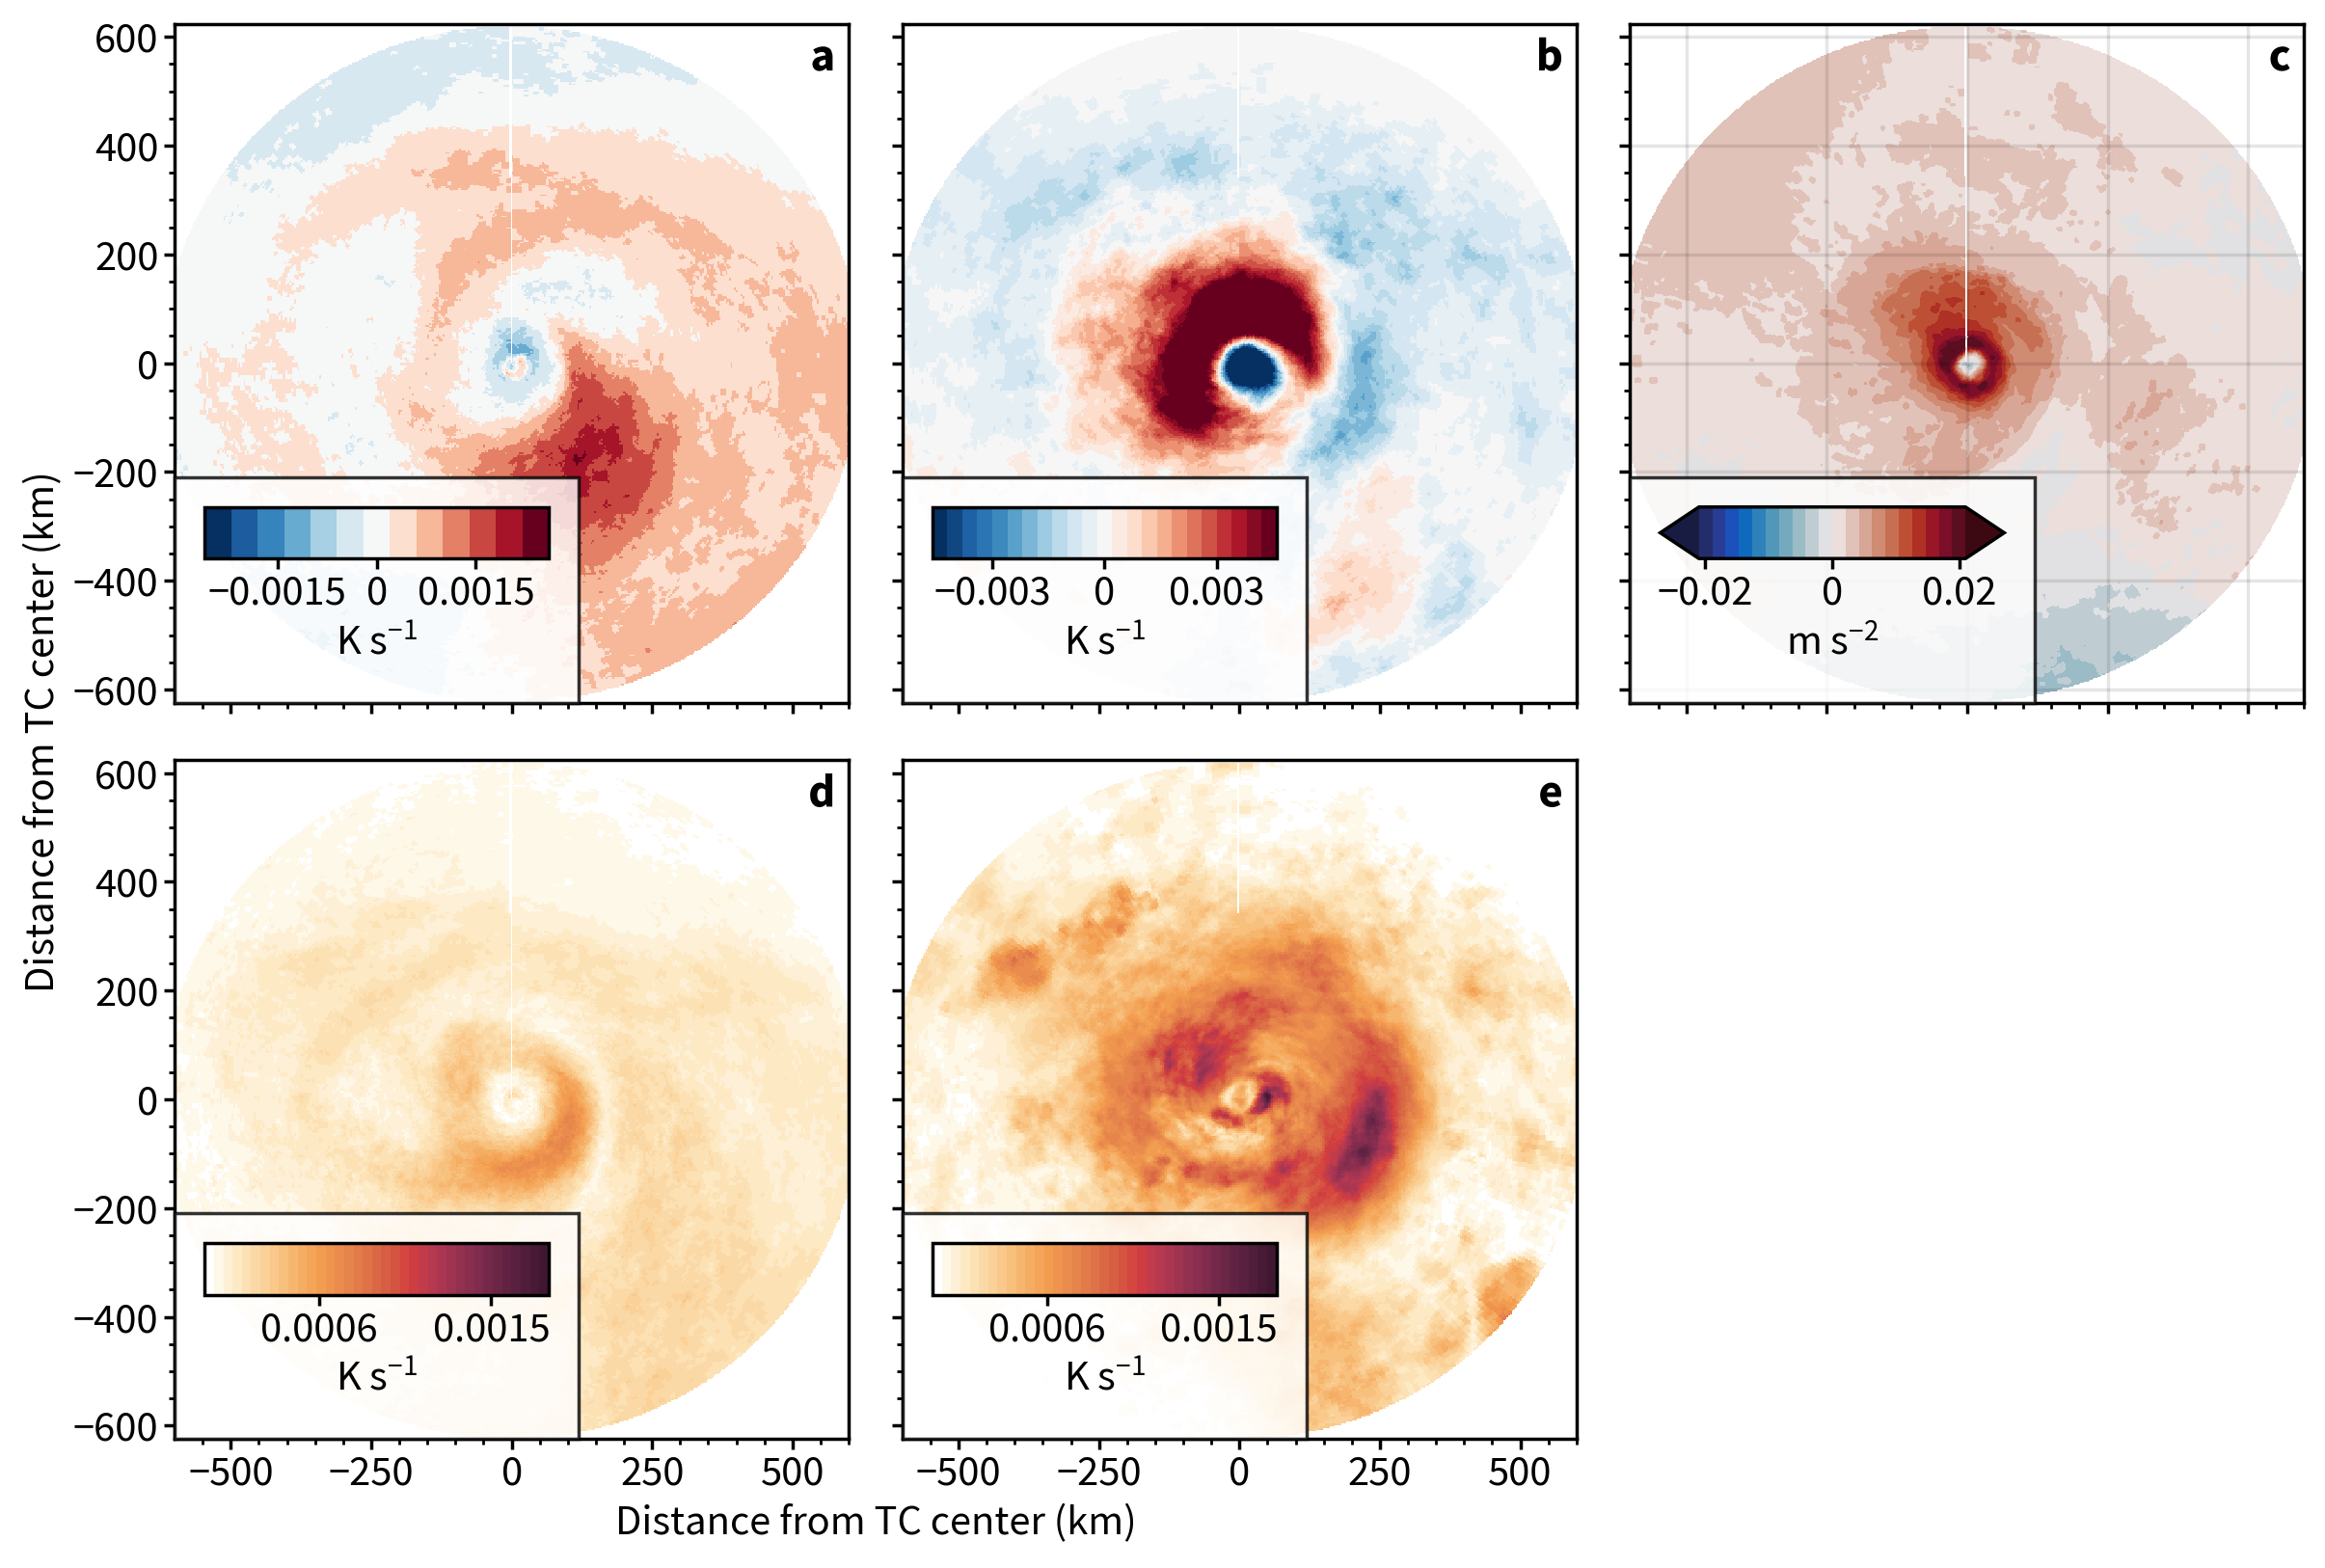

In [28]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [1000,100]
preslv = np.linspace(1000,100,10)
pressure_indx = [np.abs(preslv-obj).argmin() for obj in pressurelevel]

plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 16.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=3.495,refaspect=0.9931)
for i,obj in enumerate(pressure_indx):
    #maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.65,.65),cmap='BuRd',vmin=-3,vmax=3)
    if i==0:
        levels= np.linspace(-0.0026,0.0026,14)
        ticks = [-0.0015,0,0.0015]
    else:
        levels= np.linspace(-0.0046,0.0046,24)
        ticks = [-0.003,0,0.003]
    apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))
    values = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(flas)[obj,...],ANGLE,True,False))))[0,0]
    maps = axs[i].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(apl==values,apl),cmap='BuRd',levels=levels)
    # hatches
    #stdd = np.nanstd(np.abs(np.asarray(test_toavg)[:,5,int(obj),...]))#,45)
    #aaaa = np.ma.masked_inside((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(np.asarray(test_toavg),axis=0)[5,int(obj),...],ANGLE,True,False)))),-stdd,stdd).mask
    #axs[i].contourf(aaaa.astype(int),levels=[0,0.5,1],hatches=["////","",""],alpha=0)
    # format
    axs[i].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
    axs[i].colorbar(maps,loc='ll',ticks=ticks,label='K s$^{-1}$')

AAAu = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.std(np.asarray([np.asarray(storeLW[modelranki])[0,...] for modelranki in range(len(storeLW))]),axis=0),ANGLE,True,False))))
AAAu_u = (np.fliplr(np.flipud(read_and_proc.proc_tocart(np.std(np.asarray([np.asarray(storeLW[modelranki])[9,...] for modelranki in range(len(storeLW))]),axis=0),ANGLE,True,False))))
maps=axs[3].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(AAAu==AAAu[0,0],AAAu),cmap='fire',levels=np.linspace(0,0.0018,38))
axs[3].colorbar(maps,loc='ll',ticks=[0.0006,0.0015],label='K s$^{-1}$')
maps2=axs[4].pcolormesh(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3, np.ma.masked_where(AAAu_u==AAAu_u[0,0],AAAu_u),cmap='fire',levels=np.linspace(0,0.0018,38))
axs[4].colorbar(maps2,loc='ll',ticks=[0.0006,0.0015],label='K s$^{-1}$')
axs[3].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
axs[4].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])

wspd = ((haiyan_u[2][140-132+24]**2+haiyan_v[2][16+24]**2)**(0.5)-(haiyan_u[2][16]**2+haiyan_v[2][16]**2)**(0.5))/(60*24)
apl = (np.fliplr(np.flipud(read_and_proc.proc_tocart(wspd.reshape(10,360,208)[0],ANGLE,True,False))))
maps = axs[2].contourf(np.linspace(-208,208,417)*3, np.linspace(-208,208,417)*3,np.ma.masked_where(apl==apl[0,0],apl),cmap='balance',levels=np.linspace(-0.021,0.021,21),extend='both')
axs[2].format(xlabel='Distance from TC center (km)', ylabel='Distance from TC center (km)',xlim=[-600,600])
axs[2].colorbar(maps,loc='ll',ticks=[-0.02,0,0.02],label='m s$^{-2}$')
axs[5].set_visible(False)
axs.format(abc=True,abcloc='ur')

plt.savefig('./figures/fig4_optimstructures3D_revised_haiyan.png',dpi=600)
plt.show()

## Sample

In [196]:
import analysis
#haiyan_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
#haiyan_v = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'].shape for lime in tqdm(range(1,21))]

path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
suffixRAD = '_smooth_preproc_dict1b_g_radcomp'
haiyan_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['LW'] for lime in tqdm(range(1,21))]
haiyan_sw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/radcomp/'+'mem'+str(lime)+suffixRAD)['SW'] for lime in tqdm(range(1,21))]

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
so = []
for index in range(40):
    so.append(read._get_exp_name(folderpath2,index,'rhorig','fixTEST')[1])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [199]:
import preproc
aaaaa = preproc.train_valid_test(haiyan_lw,[int(so[valsplit2_vae][0]),int(so[valsplit2_vae][1])],[int(so[valsplit2_vae][2]),int(so[valsplit2_vae][3])],'Yes')
MEANLW = np.mean(np.mean(aaaaa[0],axis=0).reshape(10,360,208),axis=1)

In [121]:
(np.asarray([aobj.shape[0]-24 for aindx,aobj in enumerate(haiyan_lw) if aindx not in ins])).cumsum(),[aindx for aindx,aobj in enumerate(haiyan_lw) if aindx not in ins]

(array([ 79, 132, 195, 282, 353, 413, 496, 507, 515, 558, 606, 669, 745,
        805, 861, 863]),
 [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 18, 19])

## Input Perturbation

In [67]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').where_exp_MLRpred(divider=divider,num=40,expnum=2,LT=24)

start  end    exp  size
0     132  195  train    63
1     132  195  train    63
2     132  195  train    63
3     132  195  train    63
4     132  195  train    63
5     132  195  train    63
6     132  195  train    63
7     132  195  train    63
8     132  195  train    63
9     132  195  train    63
10    132  195  train    63
11    132  195  train    63
12    132  195  train    63
13    132  195  train    63
14    132  195  train    63
15    132  195  train    63
16    132  195  train    63
17    132  195  train    63
18    132  195  train    63
19    132  195  train    63
20    132  195  train    63
21    132  195  train    63
22     79  142  train    63
23    132  195  train    63
24     79  142  train    63
25    132  195  train    63
26    132  195  train    63
27     79  142  train    63
28     79  142  train    63
29     79  142  train    63
30      0   63  valid    63
31      0   63  valid    63
32    132  195  train    63
33     79  142  train    63
34    132  195  train    63
35    132  195  train    63
36     79  142  train    63
37    132  195  train    63
38    132  195  train    63
39    132  195  train    63

In [72]:
storeLOCS = []
for i in tqdm(range(20)):
    storeLOCS.append(read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').where_exp_MLRpred(divider=divider,num=40,expnum=i,LT=24).iloc[valsplit])

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
from copy import deepcopy
class best_inputpert:
    def __init__(self,bestmodel=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None):
        self.bestmodel=bestmodel
        self.X_totrain = deepcopy(X_totrain)
        self.y_totrain = deepcopy(y_totrain)
        self.X_toval = deepcopy(X_toval)
        self.y_toval = deepcopy(y_toval)
        self.X_totest = deepcopy(X_totest)
        self.y_totest = deepcopy(y_totest)

        
    def get_perturbweight(self,mean=0,sigma=1,totalnum=309,radnum=40,seed=42):
        setup_seed(seed)
        mus = []
        for t in range(totalnum):
            if t>=totalnum-radnum:
                mus.append(random.gauss(mean,sigma))
            else:
                mus.append(1)
        return mus

    def multiply(self,inputt=None,weights=None):
        store = []
        for i in range(len(inputt)):
            store.append(np.asarray(inputt[i])*weights)
        return store
        
    def get_perturbedinput(self,mean=0,sigma=1,totalnum=309,radnum=40,seed=42):
        setup_seed(seed)
        weights = self.get_perturbweight(mean,sigma,totalnum,radnum,seed)
        
        Xtrain = self.multiply(self.X_totrain,weights)#[weightt*Xtrainn for Xtrainn,weightt in zip(self.X_totrain,weights)]
        Xval = self.multiply(self.X_toval,weights)#[weightt*Xvaln for Xvaln,weightt in zip(self.X_toval,weights)]
        Xtest = self.multiply(self.X_totest,weights)#[weightt*Xtestn for Xtestn,weightt in zip(self.X_totest,weights)]
        return Xtrain,Xval,Xtest
    
    def make_perturbedpred(self,mean=0,sigma=3,totalnum=309,radnum=40,seed=42):
        Xtrainper,Xvalper,Xtestper = self.get_perturbedinput(mean,sigma,totalnum,radnum,seed)
        return {'train': np.squeeze(self.bestmodel(torch.FloatTensor(Xtrainper).to('cpu')).detach().numpy().transpose()),
                'val': np.squeeze(self.bestmodel(torch.FloatTensor(Xvalper).to('cpu')).detach().numpy().transpose()),
                'test': np.squeeze(self.bestmodel(torch.FloatTensor(Xtestper).to('cpu')).detach().numpy().transpose())}
    
def get_input(folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,valsplit=None):
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[valsplit]['lwswdtthuvw'],yall[valsplit][23][0])
    X_toval,y_toval = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[valsplit]['lwswdtthuvw'],yall[valsplit][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[valsplit]['lwswdtthuvw'],yall[valsplit][23][2])
    return X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest

In [12]:
class perturb_benchmark:
    def __init__(self,dataset=None,sigma=None,dropout_index=0):
        self.dataset = dataset
        self.sigma = sigma
        self.dropout_indx = dropout_index
        
    def get_model(self,valsplit=None):
        return [obj[0] for obj in self.dataset[self.dropout_indx][valsplit]['models']]
    
    #def get_input(self,folderpath=None,folderpath2=None,Xtrain=None,Xvalid=None,Xtest=None,yall=None,valsplit=None):
    #    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[valsplit]['lwswdtthuvw'],yall[valsplit][23][0])
    #    X_toval,y_toval = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[valsplit]['lwswdtthuvw'],yall[valsplit][23][1])
    #    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[valsplit]['lwswdtthuvw'],yall[valsplit][23][2])
    #    return X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest
    
    def get_input(self,filepath='./haiyan_store',splitnum=None,explag=23):
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*')[0])['test'][explag]
        
        X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
        X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
        X_totest, y_totest = read.delete_padding(Xtest,ytest)
        return X_totrain,y_totrain,X_tovalid,y_tovalid,X_totest,y_totest
    
    def do_inputpertCRPS(self,model=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None,mean=1,totalnum=309,radnum=40,seedlow=40,seedup=90):
        storepred = []
        for i in range(seedlow,seedup):
            storepred.append(best_inputpert(model,X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest).make_perturbedpred(mean,self.sigma,len(X_totrain[0]),radnum,seed=i))
        #print(ps.crps_ensemble(np.asarray(y_totrain).transpose(),np.asarray([obj['train'] for obj in storepred]).transpose()).mean())
        #print(aaaaa)
        crps = {'train':ps.crps_ensemble(np.asarray(y_totrain).transpose(),np.asarray([obj['train'] for obj in storepred]).transpose()).mean(),\
                'val':ps.crps_ensemble(np.asarray(y_toval).transpose(),np.asarray([obj['val'] for obj in storepred]).transpose()).mean(),\
                'test':ps.crps_ensemble(np.asarray(y_totest).transpose(),np.asarray([obj['test'] for obj in storepred]).transpose()).mean()}
        return crps,storepred
    
    def get_pertINPUTS(self,model=None,X_totrain=None,y_totrain=None,X_toval=None,y_toval=None,X_totest=None,y_totest=None,mean=1,totalnum=309,radnum=40,seedlow=40,seedup=90):
        storepred = []
        for i in range(seedlow,seedup):
            storepred.append(best_inputpert(model,X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest).get_perturbedinput(mean,self.sigma,len(X_totrain[0]),radnum,seed=i))
        return storepred
    
    def get_preds(self,totalsplit=40,filepath='./haiyan_store',explag=23):#,Xtrain=None,Xvalid=None,Xtest=None,yall=None):
        crps_out,allpred_out = [],[]
        for val_split in tqdm(range(totalsplit)):
            X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest = self.get_input(filepath=filepath,splitnum=val_split,explag=explag)#folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,val_split)
            models = self.get_model(val_split)
            
            crps = []
            allpred = []
            for model in models:
                crps_tmp,storepred_tmp = self.do_inputpertCRPS(model=model,X_totrain=X_totrain,y_totrain=y_totrain,X_toval=X_toval,y_toval=y_toval,X_totest=X_totest,y_totest=y_totest)
                crps.append(crps_tmp)
                allpred.append(storepred_tmp)
                
            crps_out.append(crps)
            allpred_out.append(allpred)
        return crps_out, allpred_out
    
    def get_multiinputs(self,totalsplit=40,filepath='./haiyan_store',explag=23):#,Xtrain=None,Xvalid=None,Xtest=None,yall=None):
        allpred_out = []
        for val_split in tqdm(range(totalsplit)):
            X_totrain,y_totrain,X_toval,y_toval,X_totest,y_totest = self.get_input(filepath=filepath,splitnum=val_split,explag=explag)#folderpath,folderpath2,Xtrain,Xvalid,Xtest,yall,val_split)
            models = self.get_model(val_split)
            
            allpred = []
            for model in models:
                storepred_tmp = self.get_pertINPUTS(model=model,X_totrain=X_totrain,y_totrain=y_totrain,X_toval=X_toval,y_toval=y_toval,X_totest=X_totest,y_totest=y_totest)
                allpred.append(storepred_tmp)
            allpred_out.append(allpred)
        return allpred_out

In [43]:
storeallsigma = {}
sigmas = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2,2.2]#[np.round(obj,2) for obj in np.linspace(0.1,2.1,21)]

for sigma in tqdm(sigmas):
    crps_out,allpred_out = perturb_benchmark(crps_performance,sigma,0).get_preds(40,'./haiyan_store',23)#,Xtrain,Xvalid,Xtest,yall)
    storeallsigma[sigma] = {'crps':crps_out,'allpred':allpred_out}

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [280]:
sigmas_n = [0,0.2]#,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2,2.2]
storeallsigma_input = {}
for sigma in tqdm(sigmas_n):
    allpred_out = perturb_benchmark(crps_performance,sigma,0).get_multiinputs(40,'./haiyan_store',23)#,Xtrain,Xvalid,Xtest,yall)
    storeallsigma[sigma] = {'allpred_inputs':allpred_out}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [71]:
read_and_proc.save_to_pickle('./haiyan_store/storesigmas.pkl',storeallsigma)

In [45]:
def proc_crps(data=None,sigma=0,allsplit=40):
    trains_crps,vals_crps,tests_crps = [],[],[]
    for i in range(allsplit):
        trains_crps.append([obj['train'] for obj in (data[sigma]['crps'])[i]])
        vals_crps.append([obj['val'] for obj in (data[sigma]['crps'])[i]])
        tests_crps.append([obj['test'] for obj in (data[sigma]['crps'])[i]])
    return trains_crps,vals_crps,tests_crps

storesigma_crps = {}
for sigma in tqdm(sigmas):
    trains_crps,vals_crps,tests_crps = proc_crps(storeallsigma,sigma,40)
    storesigma_crps[sigma] = {'train':trains_crps,'val':vals_crps,'test':tests_crps}

  0%|          | 0/12 [00:00<?, ?it/s]